# MNP Model

- agent $i$ chooses among the set of five alternaties : $C = \{1, 2, 3, 4, 5\}$ 

- Each alternative has two attributes

  $$
  \begin{aligned}
  U_{ij} &= z_{ij1}(1+\eta_{ij1}) + z_{ij2}(b+\eta_{ij2})\\
         &\equiv z_{ij1} + z_{ij2}b + v_{ij} \quad (j = 1, ..., 5, \quad i = 1, ..., n)\\
  \end{aligned}
  $$

- We assume $\eta_{ij1}, \eta_{ij2} \sim i.i.d. N(0, 1)$, and $cov(\eta_{ij1}, \eta_{ij2}) = 0$. 
  
  Then $v_{ij} \sim N(0, z_{ij1}^2 + z_{ij2}^2) \sim \Big(\sqrt{z_{ij1}^2 + z_{ij2}^2}\Big)u_{ij}$, 
  where $u_{ij} \sim N(0, 1)$.

- observed choices $y_i = (y_{i1}, \dots, y_{i5})$
  where $y_{ij} = \mathbf{1}(U_{ij} > U_{il},\forall l \neq j)$.

# Data
We assume real $b = 4.0$

In [1]:
import numpy as np
from mnp_utils import dgp

# data (b = 4.0) 
# z_ij1, z_ij2 ~ U[0, 5]
Z, Y = dgp(b = 4.0, N = 10_000, m = 5, low = 0.0, high = 10.0, seed = 1688)
print(Z.shape, Y.shape)

(10000, 5, 2) (10000, 5)


In [2]:
Y.sum(axis=0)

array([1971., 1992., 2020., 1980., 2037.])

# Moment Conditions

- observed empirical moments ($z_i$ are raw IVs)
  
  $K = [K_1 ,..., K_5]'$
  
  $K_j(y_i, z_i) = \mathbf{1}{(y_{ij} = 1)}$

- theoretical moments

  $k = [k_1, ..., k_5]'$
  
  $k_{j}\left(z_{i} ; \theta_{0}\right) 
  = E_{0}\left[K_{j}\left(y_{i}, z_{i}\right) \mid z_{i}\right]
  = P_{0}\left[y_{i j}=1 \mid z_{i}\right]$  

# Frequency Simulator 

  $\tilde{k}_j(z_i, \eta_i; b) = K_j[r(u_i, z_i; b), z_i] 
  = \mathbf{1}\big(z_{ij1} + z_{ij2}b + v_{ij} > 
  z_{il1} + z_{il2}b + v_{il} \quad \forall l \neq j \big)$

In [3]:
from mnp_utils import freq_sim
# simulator is not continuos w.r.t parameter b
np.random.seed(123)
v = np.random.normal(2, 0.5, size=5) 
print("b = 1.5:\n", freq_sim(v, z = Z[0], b = 1.5,))
print("b = 1.6:\n", freq_sim(v, z = Z[0], b = 1.6,))
print("b = 3.0:\n", freq_sim(v, z = Z[0], b = 3.0,))

b = 1.5:
 [[0.]
 [1.]
 [0.]
 [0.]
 [0.]]
b = 1.6:
 [[0.]
 [1.]
 [0.]
 [0.]
 [0.]]
b = 3.0:
 [[0.]
 [0.]
 [0.]
 [0.]
 [1.]]


# Simple Estimation (based on frequency simulator)

## MSM criteria

In [4]:
# IV function (use constant and attributes as IVs)
from mnp_utils import simple_iv
print(Z[0])
simple_iv(Z[0])

[[0.32613195 4.09545852]
 [4.32128726 8.29592807]
 [4.38696184 2.45478724]
 [5.25161259 8.17588723]
 [1.53664317 9.89311576]]


array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.32613195, 4.32128726, 4.38696184, 5.25161259, 1.53664317],
       [4.09545852, 8.29592807, 2.45478724, 8.17588723, 9.89311576]])

In [5]:
# moments function
from mnp_utils import mom 
mom(Y[0], Z[0])

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [6]:
np.sum(Z ** 2, axis = 2, keepdims=True)[0][0]

array([16.87914257])

minimizer:  4.0


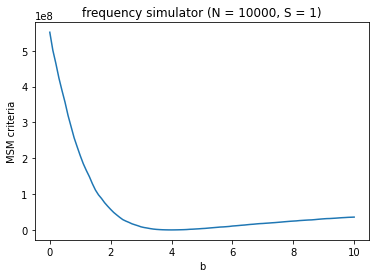

In [7]:
from mnp_utils import msm_criteria
import matplotlib.pyplot as plt

np.random.seed(42)

# real b = 4.0
N = 10_000
m = 5
Z, Y = dgp(b = 4.0, N = N, m = m, low = 0.0, high = 10.0, seed = 1688)

S = 1
V = np.empty((N, S, m))
u = np.random.normal(0, 1, (N, S, m))
std = np.sum(Z ** 2, axis = 2) ** 0.5
for s in range(S):
    V[:, s, :] = std * u[:, s, :]


criteria_list = []
for b in np.linspace(0, 10, 101):
    criteria_list.append(msm_criteria(b, Z=Z, Y=Y, iv=simple_iv, mom_func=mom, 
                                 simulator=freq_sim, V=V, S=S, W=None))

print("minimizer: ", np.linspace(0, 10, 101)[np.argmin(criteria_list)])

plt.plot(np.linspace(0, 10, 101), criteria_list)
plt.xlabel("b")
plt.ylabel("MSM criteria")
plt.title(f"frequency simulator (N = {N}, S = {S})")
plt.show()

## Estimation

In [8]:
from mnp_utils import msm_estimator

msm_estimator(Z, Y, iv=simple_iv, mom_func=mom, simulator=freq_sim, S=S, W=None, x0=1.0, seed=42)

array([3.996875])

## bootstrap standard errors

In [9]:
# bootstrap standard errors
np.random.seed(123456)
N = 10_000 # number of observations
S = 1 # one simulation
m = 5 # number of alternatives
Z, Y = dgp(b = 4.0, N = N, m = m, low = 0.0, high = 10.0, seed = 1688)

b_sample_size=200 # bootstrap sample size
all_ind = np.random.choice(np.arange(N), (b_sample_size, N), replace=True)
b_est = np.empty(b_sample_size) # estimates list

for i in range(b_sample_size):
    ind = all_ind[i]
    Z_b = Z[ind, :, :]
    Y_b = Y[ind, :]
    b_est[i] = msm_estimator(Z_b, Y_b, iv=simple_iv, mom_func=mom, simulator=freq_sim, S=S, 
                           W=None, x0=1.0, seed=42)

95% CI:  [3.9059375000000065, 4.322421875000007]
bootstrap standard error: 0.09761120765935548


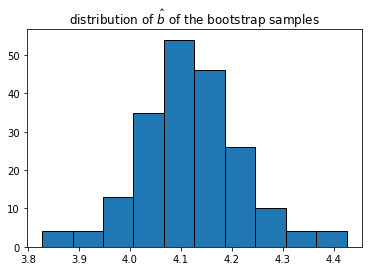

In [10]:
plt.hist(b_est, edgecolor='black')
plt.title("distribution of $\hat{b}$ of the bootstrap samples")
print("95% CI: ", [np.percentile(b_est, 2.5), np.percentile(b_est, 97.5)])
print("bootstrap standard error:", np.std(b_est))

## monte carlo simulation

se(b):  0.09029626778845493


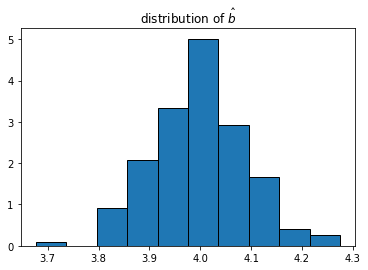

In [11]:
n_sim = 200 # number of mote carlo simulations
mc_ests = np.empty(n_sim)
N = 10_000 # number of observations
S = 1 # one simulation
m = 5 # number of alternatives

for i in range(n_sim):
    Z, Y = dgp(b = 4.0, N = N, m = m, low = 0.0, high = 10.0, seed = i)
    mc_ests[i] = msm_estimator(Z, Y, iv=simple_iv, mom_func=mom, simulator=freq_sim, S=S, 
                             W=None, x0=1.0, seed=42)

print("se(b): ", np.std(mc_ests))
plt.hist(mc_ests, edgecolor='black', density=True)
plt.title("distribution of $\hat{b}$")
plt.show()

# Stern Simulator

$k_{j}\left(z_{i} ; \theta_{0}\right) 
  = E_{0}\left[K_{j}\left(y_{i}, z_{i}\right) \mid z_{i}\right]
  = P_{0}\left[y_{i j}=1 \mid z_{i}\right]$  

We want to simulate the probability for $i$ choosing $j$ directly.
 
Consider the variables measuring the differences between the utility levels:
$$
r_{j \ell}=U_{i j}-U_{i \ell}, 
\quad r_{j \ell} 
\sim N\Big((z_{ij1} - z_{il1}) + (z_{ij2} - z_{il2})b, 
\quad z_{ij1}^2 + z_{il1}^2 + z_{ij2}^2 + z_{il2}^2 \Big)
$$
Then $P_{0}\left[y_{i j}=1 \mid z_{i}\right] = Pr(r_{il} > 0 \quad \forall l \neq j) $ 

The distribution of $r_j = [r_{j 1}, \ldots, r_{j, j-1}, r_{j, j+1}, \ldots, r_{j, 5}]^{\prime}$ is a normal distribution $N(\mu, \Sigma)$. 

$\Sigma_{lp} = Cov(r_{jl}, r_{jp}) = z_{ij1}^2 + z_{ij2}^2 \quad (l \neq p)$.

Set $\lambda$ to be the smallest eigenvalue of $\Sigma$, then $\Sigma = {\lambda} I + CC^{'}$.

Then $Cu + \sqrt{\lambda} w \sim N(0, \Sigma)$, where $u, w \sim i.i.d N(0, I_{m-1})$.
Denote $l$-th row of $C$ by $c_l$: 
$$
\begin{aligned}
Pr(r_{il} > 0) &= Pr\Big(-(z_{ij1} - z_{il1}) + (z_{ij2} - z_{il2})b
< c_{l}u + \sqrt{\lambda}w_j\Big)\\ 
&= Pr(w_j > \frac{-(z_{ij1} - z_{il1}) + (z_{ij2} - z_{il2})b - c_j{u}}{\sqrt{\lambda}})\\
&= 1 - \Phi(\frac{-(z_{ij1} - z_{il1}) + (z_{ij2} - z_{il2})b - c_j{u}}{\sqrt{\lambda}})
\end{aligned}
$$

What we need to do is to draw $u$ from the ($m-1$ dimension) standard normal distribution for each $i, j$.

$Pr(r_{il} > 0, \forall l \neq j) = \Pi_{l\neq j} Pr(r_{il} > 0)$.

In [12]:
from mnp_utils import stern_sim, msm_estimator

In [13]:
np.random.seed(123456)
N = 10_000 # number of observations
S = 1 # one simulation
m = 5 # number of alternatives
Z, Y = dgp(b = 4.0, N = N, m = m, low = 0.0, high = 10.0, seed = 1688)

u = np.random.normal(size=(m, m-1))
stern_sim(u, Z[2001], b=2.0), Y[2001]

(array([[1.07120369e-03],
        [3.13425764e-01],
        [1.95136620e-11],
        [7.06339613e-04],
        [2.13429403e-05]]),
 array([1., 0., 0., 0., 0.]))

## MSM criteria 

minimizer:  4.0


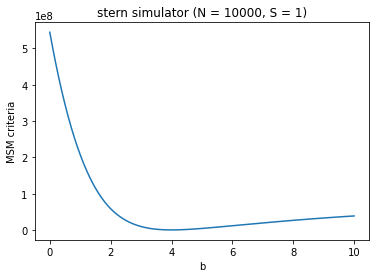

In [14]:
np.random.seed(42)

# real b = 4.0
N = 10_000
m = 5
Z, Y = dgp(b = 4.0, N = N, m = m, low = 0.0, high = 10.0, seed = 1688)

S = 1
U = np.random.normal(size=(N, S, m, m-1))

criteria_list = []
for b in np.linspace(0, 10, 101):
    criteria_list.append(msm_criteria(b, Z=Z, Y=Y, iv=simple_iv, mom_func=mom, 
                                      simulator=stern_sim, V=U, S=S, W=None))

print("minimizer: ", np.linspace(0, 10, 101)[np.argmin(criteria_list)])

plt.plot(np.linspace(0, 10, 101), criteria_list)
plt.xlabel("b")
plt.ylabel("MSM criteria")
plt.title(f"stern simulator (N = {N}, S = {S})")
plt.show()

## Estimation

In [15]:
msm_estimator(Z, Y, iv=simple_iv, mom_func=mom, simulator=stern_sim, S=S, W=None, x0=0.0, seed=42, 
              method="BFGS", simulator_name="stern")

array([4.00163947])

## monte carlo simulation

se(b):  0.10862095692215618


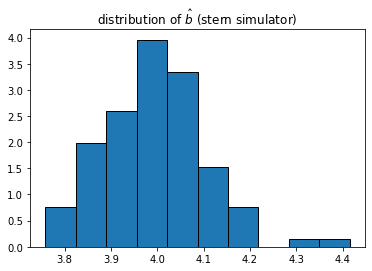

In [16]:
n_sim = 100 # number of mote carlo simulations
mc_ests = np.empty(n_sim)
N = 10_000 # number of observations
S = 1 # one simulation
m = 5 # number of alternatives

for i in range(n_sim):
    Z, Y = dgp(b = 4.0, N = N, m = m, low = 0.0, high = 10.0, seed = i)
    mc_ests[i] = msm_estimator(Z, Y, iv=simple_iv, mom_func=mom, simulator=stern_sim, S=S, 
                             W=None, x0=1.0, seed=42, method="BFGS", simulator_name="stern")

print("se(b): ", np.std(mc_ests))
plt.hist(mc_ests, edgecolor='black', density=True)
plt.title("distribution of $\hat{b}$ (stern simulator)")
plt.show()

# Covariance Matrix

In [17]:
import importlib
import mnp_utils
importlib.reload(mnp_utils)
from mnp_utils import approx_moments, msm_criteria, cov_estimator

# approximate theoretical moments for one observation
S2 = 100
U = np.random.normal(0, 1, (S2, m, m-1))
approx_moments(4.0, Z[10], simulator=stern_sim, U=U)

array([[5.31423802e-01],
       [4.19974742e-03],
       [2.10104678e-02],
       [1.81136258e-06],
       [4.28198268e-01]])

# Two-Stage Estimation

In [18]:
# first use identity weighting matrix 
b1 = msm_estimator(Z, Y, iv=simple_iv, mom_func=mom, simulator=stern_sim, S=S, W=None, 
                   x0=0.0, seed=42, method="BFGS", simulator_name="stern")[0]

# asymptotic covariance matrix and optimal weighting matrix
var1, optimal_W = cov_estimator(b1, Z, Y, iv=simple_iv, mom_func=mom, simulator=stern_sim, 
                              W=None, seed=2008, simulator_name="stern", 
                              S=1, S2=100,)

# second stage estimation using optimal weighting matrix
b2 = msm_estimator(Z, Y, iv=simple_iv, mom_func=mom, simulator=stern_sim, S=S, W=optimal_W, 
                   x0=0.0, seed=42, method="BFGS", simulator_name="stern")[0]
                   
var2, *_ = cov_estimator(b2, Z, Y, iv=simple_iv, mom_func=mom, simulator=stern_sim, 
                     W=optimal_W, seed=2008, simulator_name="stern", 
                     S = 1, S2=100, optimal_weighting=True)

In [19]:
print("two-stage estimation\nb = {:.3f}\nse(b) = {:.3f}".format(b2, np.sqrt(var2[0, 0] / N)))

two-stage estimation
b = 4.098
se(b) = 0.081
